# Data loading

In [1]:
#  to present any diagrams inline with the rest of the notebook as opposed to in new browser window
%matplotlib inline 

# importing necessary modules
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
import numpy as np
from sklearn.dummy import DummyRegressor, DummyClassifier
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.metrics import mean_absolute_error, classification_report
from scipy.stats import norm
from scipy import stats, integrate
from sklearn import cross_validation
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, KFold, cross_val_predict, cross_val_score, train_test_split, StratifiedKFold

path_to_csv = "data/abalone.csv"
default_figure_out_path = 'figs/'
default_figure_ext = '.png'

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


### Specifying data indices
In order to easily identify data, which in the dataset provided doesn't have headers specified, we need to name our columns. 
At the same time we can add indices to the columns to speed up computations and enable random access to data.

In [2]:
df = pd.read_csv(path_to_csv, names=['sex', 'length', 'diameter', 'height', 'whole_weight', 'shucked_weight','viscera_weight', 'shell_weight','rings'], header=None)

We need to verify that the data was imported successfully. The easiest avenue is to check the head and tail of the dataset

In [3]:
df.head()

,sex,length,diameter,height,whole_weight,shucked_weight,viscera_weight,shell_weight,rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7


In [4]:
df.tail()

,sex,length,diameter,height,whole_weight,shucked_weight,viscera_weight,shell_weight,rings
4172,F,0.565,0.450,0.165,0.8870,0.3700,0.2390,0.2490,11
4173,M,0.590,0.440,0.135,0.9660,0.4390,0.2145,0.2605,10
4174,M,0.600,0.475,0.205,1.1760,0.5255,0.2875,0.3080,9
4175,F,0.625,0.485,0.150,1.0945,0.5310,0.2610,0.2960,10
4176,M,0.710,0.555,0.195,1.9485,0.9455,0.3765,0.4950,12


# Data cleaning
## Checking for empty records
The very first thing that needs to be performed on any dataset, before any analysis can be perfoermed is cleaning the data. The rationale behind it is that missing records can and will skew any computations done on the dataset. We can use `isnull` method inherent to any `Data Frame`.

First we need to make sure all types are numeric

In [5]:
df.dtypes

sex                object
length            float64
diameter          float64
height            float64
whole_weight      float64
shucked_weight    float64
viscera_weight    float64
shell_weight      float64
rings              object
dtype: object

In [6]:
# convert rings to number. Any text will turn into NaN. Suppressing errors with `coerce`
df['rings'] = pd.to_numeric(df['rings'], errors='coerce')
df.dtypes

sex                object
length            float64
diameter          float64
height            float64
whole_weight      float64
shucked_weight    float64
viscera_weight    float64
shell_weight      float64
rings             float64
dtype: object

In [7]:
# checking that shape of the dataset didn't change as part of the conversion operation
df.shape

(4177, 9)

In [8]:
nan_error = df.isnull().any(axis=1)
df[nan_error]

,sex,length,diameter,height,whole_weight,shucked_weight,viscera_weight,shell_weight,rings
878,F,0.635,0.485,0.165,1.2945,0.6680,NaN,0.2715,9.0
1888,F,0.565,0.445,0.125,0.8305,0.3135,0.1785,0.2300,NaN
3093,NaN,0.520,0.430,0.150,0.7280,0.3020,0.1575,0.2350,11.0
3466,M,0.640,0.500,0.170,1.4545,0.6420,0.3575,0.3540,NaN


From the data above we can see that some records are missing data:
 - Row 878 is missing `viscera weight` property
 - Row 1888 is missing `rings` value
 - Row 3093 doesn't have value for `sex` specified

## Checking dataset for errorenous data
Before re remove any data we shoul analyze if there are any errors in the dataset. It should e done before removal of any data as if the number or errors in data is significant in may become necessary to substitute wrong data and at the same time it may be possible to fill the data gaps as well.
### Values below or equal to 0
For abalone, as a living organism, it doesn't make sense for any of its attributes to be below or equal to zero.

In [9]:
df.describe()

,length,diameter,height,whole_weight,shucked_weight,viscera_weight,shell_weight,rings
count,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4176.000000,4177.000000,4175.000000
mean,0.523992,0.407675,0.139516,0.828742,0.359367,0.180574,0.238831,9.933653
std,0.120093,0.100082,0.041827,0.490389,0.221963,0.109620,0.139203,3.224867
min,0.075000,-0.430000,0.000000,0.002000,0.001000,0.000500,0.001500,1.000000
25%,0.450000,0.350000,0.115000,0.441500,0.186000,0.093375,0.130000,8.000000
50%,0.545000,0.425000,0.140000,0.799500,0.336000,0.170750,0.234000,9.000000
75%,0.615000,0.480000,0.165000,1.153000,0.502000,0.252625,0.329000,11.000000
max,0.815000,0.650000,1.130000,2.825500,1.488000,0.760000,1.005000,29.000000


In [10]:
below_or_zero=df[df <= 0.0 ].count()
below_or_zero

sex               4176
length               0
diameter             1
height               2
whole_weight         0
shucked_weight       0
viscera_weight       0
shell_weight         0
rings                0
dtype: int64

We're not concerned with `sex` column being reported as it's not a numeric data. For the rings data we need to check it with `integer` type applied instead of a floating point one.

From the description and computation we see that there are a min of 0 for height and a negative value for diameter which in case of a living organism like abalone isn't valid. We need to track down which row exactly contain error data and remove them.

In [11]:
error_diameter=df['diameter'] <= 0.0
error_height = df['height'] <= 0.0
df[error_diameter]

,sex,length,diameter,height,whole_weight,shucked_weight,viscera_weight,shell_weight,rings
2758,M,0.535,-0.43,0.155,0.7845,0.3285,0.169,0.245,10.0


In [12]:
df[error_height]

,sex,length,diameter,height,whole_weight,shucked_weight,viscera_weight,shell_weight,rings
1257,I,0.430,0.34,0.0,0.428,0.2065,0.0860,0.1150,8.0
3996,I,0.315,0.23,0.0,0.134,0.0575,0.0285,0.3505,6.0


Now that we know that there are negative values in the dataset we need to locate and remove them.

In [13]:
# tuning graph to look for negative diameter. Start at full dataset and then manipulate location param to narrow down focus
#df.loc[2750:2760].plot(figsize=(16,12), title='Partial scatterplot - identifying negative values')

## Analyzing data for domain errors
Endemic to abalone itself it is invalid for any specimen to have:
 - higher weight when shucked (stripped of its shell) than whole weight
 - higher viscera weight than whole weight
 - higher shell weight than whole weight

We can do 2 things to find the errors:
 - computation method
 - scatter matrix dedicated to specific parameters listed above

While it is possible to identify errors using visual method by narrowing down the graph field to precise location of the errorneous data it is much faster to compute it.

In [14]:
shucked_error =df['shucked_weight'] > df['whole_weight']
df[shucked_error]

,sex,length,diameter,height,whole_weight,shucked_weight,viscera_weight,shell_weight,rings
1216,I,0.310,0.225,0.070,0.1055,0.4350,0.0150,0.0400,5.0
2627,I,0.275,0.205,0.070,0.1055,0.4950,0.0190,0.0315,5.0
2641,I,0.475,0.365,0.100,0.1315,0.2025,0.0875,0.1230,7.0
3086,I,0.355,0.270,0.075,0.2040,0.3045,0.0460,0.0595,7.0


In [15]:
df[df['viscera_weight'] > df['whole_weight']]

,sex,length,diameter,height,whole_weight,shucked_weight,viscera_weight,shell_weight,rings


In [16]:
shell_error = df['shell_weight'] > df['whole_weight']
df[shell_error]

,sex,length,diameter,height,whole_weight,shucked_weight,viscera_weight,shell_weight,rings
3996,I,0.315,0.23,0.0,0.134,0.0575,0.0285,0.3505,6.0


## Summary of errorenous data
We have 4 rows with non-numerical values:
 - 878
 - 1888
 - 3093
 - 3466
 
7 rows with data that cannot be correct for domain reasons:
 - 4 where shucked weight is higher than whole weight
   - 1216
   - 2627
   - 2641
   - 3086
 - 1 row with negative value for diameter
   - 2758
 - 2 rows with 0 value for height
   - 1257
   - 3996

Row 3996 has been flagged by 2 checks as one containing impossible values: height and shell weight higher than whole weight, however, is only contributes towards row-error count once.
 
In summary we have 11 rows that either have to have some of the values substituted or removed.

From checking the tail of the dataset in previous section we know that the dataset contains 4176 rows. 

As such 10 rows with missing data comprises less than 0.26% of the dataset and removing such a small amount or errorenous data should not affect our analysis significantly. 
Had the number been more significant the missing data would have had to been substituted.

# Removing error data

In [17]:
# deleting shucked weight > whole weight
df.drop(df.index[(shucked_error) | (error_diameter) | (error_height) | (nan_error)], inplace=True)

#verifying shucked > whole that records were dropped
df[df['shucked_weight'] > df['whole_weight']]

,sex,length,diameter,height,whole_weight,shucked_weight,viscera_weight,shell_weight,rings


In [18]:
# verifying NaN errors were deleted
df[df.isnull().any(axis=1)]

,sex,length,diameter,height,whole_weight,shucked_weight,viscera_weight,shell_weight,rings


In [19]:
#verifying diameter < 0 records were dropped
df[df['diameter'] <= 0.0]

,sex,length,diameter,height,whole_weight,shucked_weight,viscera_weight,shell_weight,rings


In [20]:
# verifying height <= 0 was dropped
df[df['height'] <= 0.0]

,sex,length,diameter,height,whole_weight,shucked_weight,viscera_weight,shell_weight,rings


# Indentifying outliers
## Box Plots

In [21]:
def set_16x16_figure():
    sb.set(rc={'figure.figsize':(16,16)})
def set_11x8_figure():
    sb.set(rc={'figure.figsize':(11,8)})
def set_7x5_figure():
    sb.set(rc={'figure.figsize':(7,5)})

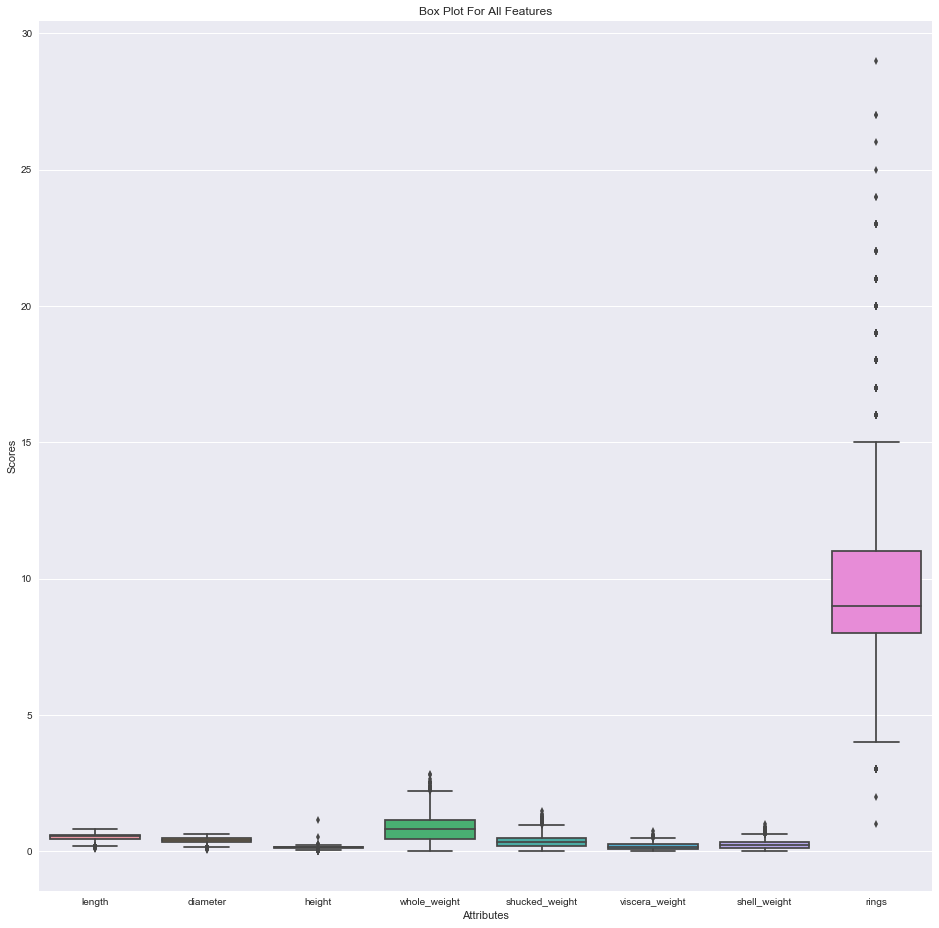

In [22]:
set_16x16_figure()
ax=sb.boxplot(data=df)
ax.set(xlabel='Attributes', ylabel='Scores', title="Box Plot For All Features")
plt.savefig(default_figure_out_path+'boxplot_all_features'+default_figure_ext, bbox_inches='tight')

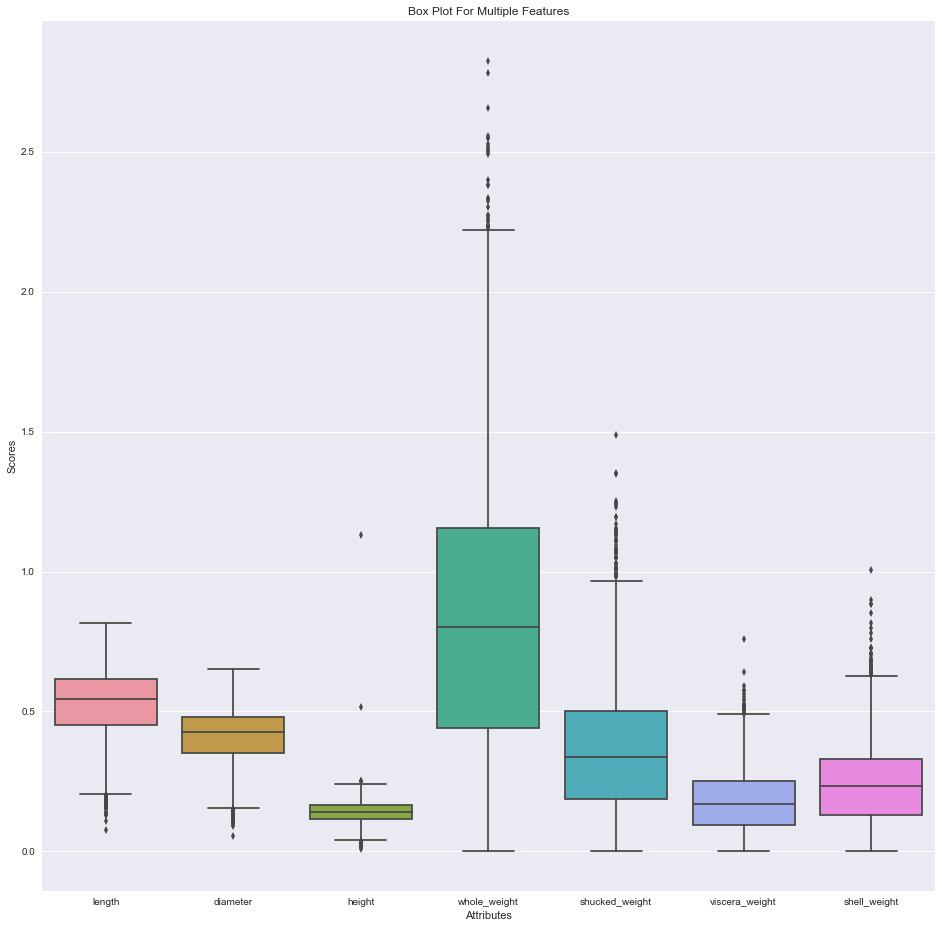

In [23]:
set_16x16_figure()
df_ringless=df.drop('rings',  axis='columns')
ax=sb.boxplot(data=df_ringless)
ax.set(xlabel='Attributes', ylabel='Scores', title="Box Plot For Multiple Features")
plt.savefig(default_figure_out_path+'boxplot_all_features_but_rings'+default_figure_ext, bbox_inches='tight')

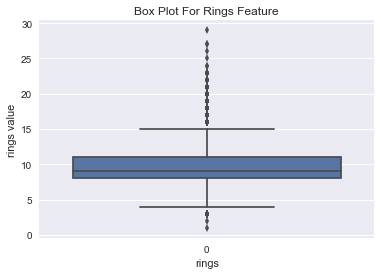

In [24]:
sb.set(rc={'figure.figsize':(6,4)})
ax=sb.boxplot(data=df['rings'])
ax.set(xlabel='rings', ylabel='rings value', title="Box Plot For Rings Feature")
plt.savefig(default_figure_out_path+'boxplot_rings'+default_figure_ext, bbox_inches='tight')

In [25]:
q1 = df['rings'].quantile(0.25)
q3 = df['rings'].quantile(0.75)
iqr = q3 - q1
lw = q1 - 1.5 * iqr
uw = q3 + 1.5 * iqr
q1, q3, iqr, lw, uw

(8.0, 11.0, 3.0, 3.5, 15.5)

In [26]:
outliers = (df['rings'] < lw) | (df['rings'] > uw) #6.67 % of the dataset
pre_outliers_removal_df_count = df['sex'].count()
df['rings'][~outliers].count()

3888

In [27]:
removed_rings = df['rings'][outliers]
df.drop(df.index[outliers], inplace=True)
removed_rings.count(), df.count()

(278, sex               3888
 length            3888
 diameter          3888
 height            3888
 whole_weight      3888
 shucked_weight    3888
 viscera_weight    3888
 shell_weight      3888
 rings             3888
 dtype: int64)

In [28]:
q1 = df['whole_weight'].quantile(0.25)
q3 = df['whole_weight'].quantile(0.75)
iqr = q3 - q1
lw = q1 - 1.5 * iqr

uw = q3 + 1.5 * iqr
#q1, q3, iqr, lw, uw
outliers = (df['whole_weight'] < lw) | (df['whole_weight'] > uw)
df['whole_weight'][outliers].count()

31

In [29]:
removed_whole_weight = df['whole_weight'][outliers]
df.drop(df.index[outliers], inplace=True)
removed_whole_weight.count(),df.count()

(31, sex               3857
 length            3857
 diameter          3857
 height            3857
 whole_weight      3857
 shucked_weight    3857
 viscera_weight    3857
 shell_weight      3857
 rings             3857
 dtype: int64)

In [30]:
q1 = df['length'].quantile(0.25)
q3 = df['length'].quantile(0.75)
iqr = q3 - q1
lw = q1 - 1.5 * iqr

uw = q3 + 1.5 * iqr
#q1, q3, iqr, lw, uw
outliers = (df['length'] < lw) | (df['length'] > uw)
df['length'][outliers].count()

30

In [31]:
removed_length = df['length'][outliers]
df.drop(df.index[outliers], inplace=True)
removed_length.count(), df.count()

(30, sex               3827
 length            3827
 diameter          3827
 height            3827
 whole_weight      3827
 shucked_weight    3827
 viscera_weight    3827
 shell_weight      3827
 rings             3827
 dtype: int64)

In [32]:
q1 = df['diameter'].quantile(0.25)
q3 = df['diameter'].quantile(0.75)
iqr = q3 - q1
lw = q1 - 1.5 * iqr

uw = q3 + 1.5 * iqr
#q1, q3, iqr, lw, uw
outliers = (df['diameter'] < lw) | (df['diameter'] > uw)
df['diameter'][outliers].count()

7

In [33]:
removed_diameter = df['diameter'][outliers]
df.drop(df.index[outliers], inplace=True)
removed_diameter.count(), df.count()

(7, sex               3820
 length            3820
 diameter          3820
 height            3820
 whole_weight      3820
 shucked_weight    3820
 viscera_weight    3820
 shell_weight      3820
 rings             3820
 dtype: int64)

In [34]:
q1 = df['height'].quantile(0.25)
q3 = df['height'].quantile(0.75)
iqr = q3 - q1
lw = q1 - 1.5 * iqr

uw = q3 + 1.5 * iqr
#q1, q3, iqr, lw, uw
outliers = (df['height'] < lw) | (df['height'] > uw)
df['height'][outliers].count()

3

In [35]:
removed_height = df['height'][outliers]
df.drop(df.index[outliers], inplace=True)
removed_height.count(), df.count()

(3, sex               3817
 length            3817
 diameter          3817
 height            3817
 whole_weight      3817
 shucked_weight    3817
 viscera_weight    3817
 shell_weight      3817
 rings             3817
 dtype: int64)

In [36]:
q1 = df['shucked_weight'].quantile(0.25)
q3 = df['shucked_weight'].quantile(0.75)
iqr = q3 - q1
lw = q1 - 1.5 * iqr

uw = q3 + 1.5 * iqr
#q1, q3, iqr, lw, uw
outliers = (df['shucked_weight'] < lw) | (df['shucked_weight'] > uw)
df['shucked_weight'][outliers].count()

20

In [37]:
removed_shucked_weight = df['shucked_weight'][outliers]
df.drop(df.index[outliers], inplace=True)
removed_shucked_weight.count(), df.count()

(20, sex               3797
 length            3797
 diameter          3797
 height            3797
 whole_weight      3797
 shucked_weight    3797
 viscera_weight    3797
 shell_weight      3797
 rings             3797
 dtype: int64)

In [38]:
q1 = df['viscera_weight'].quantile(0.25)
q3 = df['viscera_weight'].quantile(0.75)
iqr = q3 - q1
lw = q1 - 1.5 * iqr

uw = q3 + 1.5 * iqr
#q1, q3, iqr, lw, uw
outliers = (df['viscera_weight'] < lw) | (df['viscera_weight'] > uw)
df['viscera_weight'][outliers].count()

16

In [39]:
removed_viscera_weight = df['viscera_weight'][outliers]
df.drop(df.index[outliers], inplace=True)
removed_viscera_weight.count(), df.count()

(16, sex               3781
 length            3781
 diameter          3781
 height            3781
 whole_weight      3781
 shucked_weight    3781
 viscera_weight    3781
 shell_weight      3781
 rings             3781
 dtype: int64)

In [40]:
q1 = df['shell_weight'].quantile(0.25)
q3 = df['shell_weight'].quantile(0.75)
iqr = q3 - q1
lw = q1 - 1.5 * iqr

uw = q3 + 1.5 * iqr
#q1, q3, iqr, lw, uw
outliers = (df['shell_weight'] < lw) | (df['shell_weight'] > uw)
df['shell_weight'][outliers].count()

11

In [41]:
removed_shell_weight = df['shell_weight'][outliers]
df.drop(df.index[outliers], inplace=True)
removed_shell_weight.count(), df.count()

(11, sex               3770
 length            3770
 diameter          3770
 height            3770
 whole_weight      3770
 shucked_weight    3770
 viscera_weight    3770
 shell_weight      3770
 rings             3770
 dtype: int64)

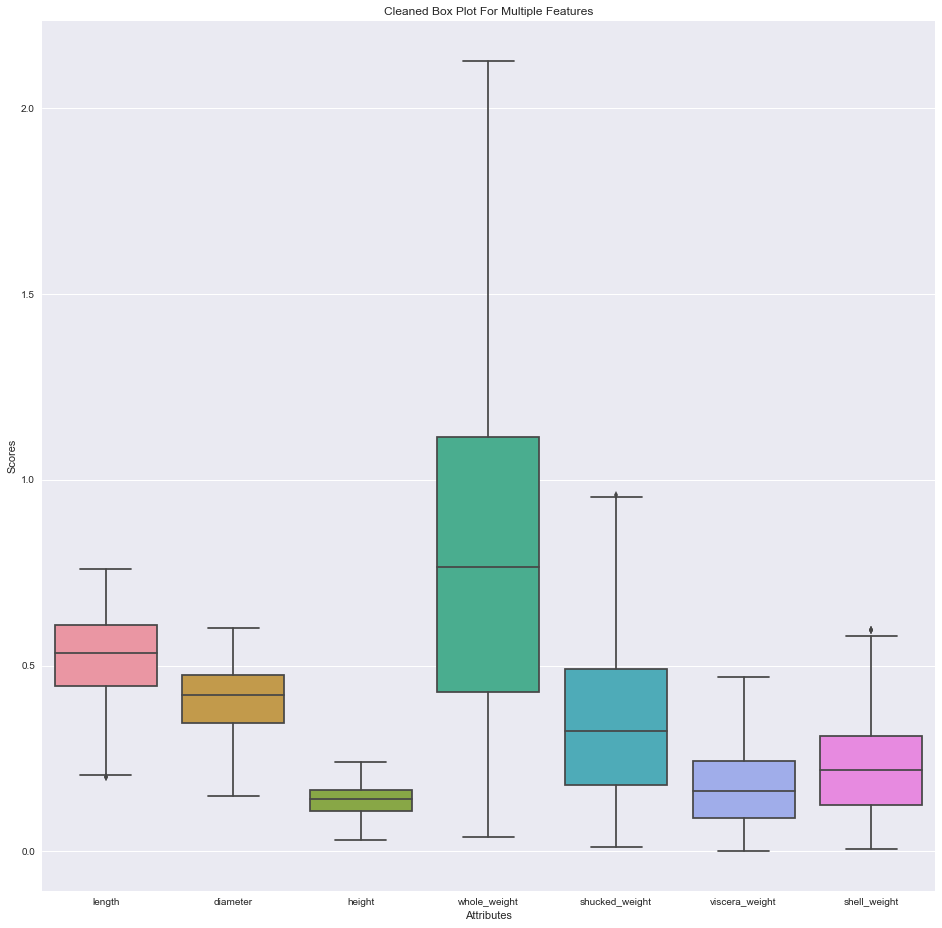

In [42]:
set_16x16_figure()
df_ringless=df.drop('rings',  axis='columns')
ax=sb.boxplot(data=df_ringless)
ax.set(xlabel='Attributes', ylabel='Scores', title="Cleaned Box Plot For Multiple Features")
plt.savefig(default_figure_out_path+'boxplot_all_features_cleaned'+default_figure_ext, bbox_inches='tight')

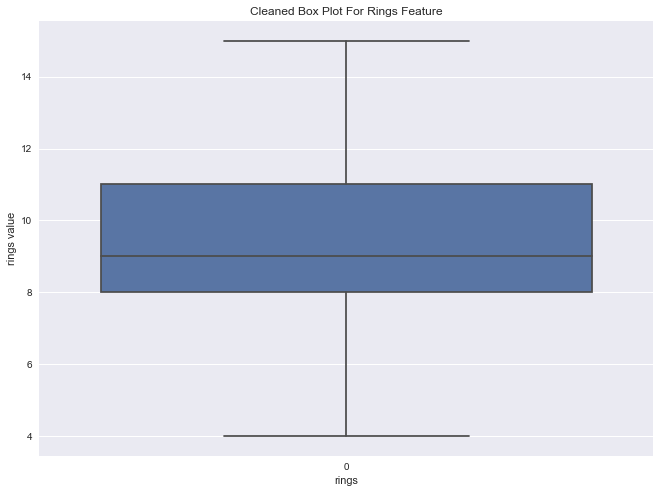

In [43]:
set_11x8_figure()
ax=sb.boxplot(data=df['rings'])
ax.set(xlabel='rings', ylabel='rings value', title="Cleaned Box Plot For Rings Feature")
plt.savefig(default_figure_out_path+'boxplot_rings_cleaned'+default_figure_ext, bbox_inches='tight')

In [44]:
total_outliers = removed_rings.count()+removed_whole_weight.count()+removed_length.count()+removed_diameter.count()+removed_height.count()+removed_shucked_weight.count()+removed_viscera_weight.count()+removed_shell_weight.count()

print('Total number of outliers removed from the dataset across all features:', total_outliers)
percent_of_dataset = total_outliers/pre_outliers_removal_df_count *100
print('Accounts for the ', percent_of_dataset, ' of the dataset post-errorenous data cleanup')

Total number of outliers removed from the dataset across all features: 396
Accounts for the  9.505520883341333  of the dataset post-errorenous data cleanup


In [45]:
# ax=sb.boxplot(data=df['viscera_weight'])
# ax.set(xlabel='viscera weight', ylabel='viscera weight value', title="Box Plot For Viscera Weight")

# ax=sb.boxplot(data=df['shell_weight'])
# ax.set(xlabel='shell weight', ylabel='shell weight value', title="Box Plot For Shell Weight")

# ax=sb.boxplot(data=df['shucked_weight'])
# ax.set(xlabel='shucked weight', ylabel='shucked weight value', title="Box Plot For Shucked Weight")
# ax=sb.boxplot(data=df['whole_weight'])
# ax.set(xlabel='whole weight', ylabel='whole weight value', title="Box Plot For Whole Weight")
# ax=sb.boxplot(data=df['height'])
# ax.set(xlabel='height', ylabel='height value', title="Box Plot For Height")
# ax=sb.boxplot(data=df['diameter'])
# ax.set(xlabel='diameter', ylabel='diameter value', title="Box Plot For Diameter")
# ax=sb.boxplot(data=df['length'])
# ax.set(xlabel='length', ylabel='length value', title="Box Plot For Length")

# Identifying feature correlation

In [46]:
# most basic way to show correlation between data. Exposes candidates for scatter matrices
df.corr()

,length,diameter,height,whole_weight,shucked_weight,viscera_weight,shell_weight,rings
length,1.000000,0.986135,0.895720,0.940527,0.916886,0.914097,0.923939,0.590158
diameter,0.986135,1.000000,0.901184,0.938694,0.910587,0.908830,0.930177,0.607120
height,0.895720,0.901184,1.000000,0.894243,0.850334,0.874830,0.902273,0.618484
whole_weight,0.940527,0.938694,0.894243,1.000000,0.974949,0.966773,0.962484,0.561778
shucked_weight,0.916886,0.910587,0.850334,0.974949,1.000000,0.931820,0.905760,0.472681
viscera_weight,0.914097,0.908830,0.874830,0.966773,0.931820,1.000000,0.923066,0.547305
shell_weight,0.923939,0.930177,0.902273,0.962484,0.905760,0.923066,1.000000,0.625005
rings,0.590158,0.607120,0.618484,0.561778,0.472681,0.547305,0.625005,1.000000


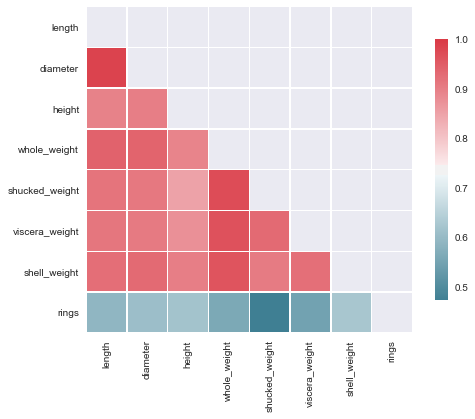

In [47]:
corr = df.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(8, 6))
cmap = sb.diverging_palette(220, 10, as_cmap=True)
sb.heatmap(corr, mask=mask, cmap=cmap, vmax=1,square=True, linewidths=.5, cbar_kws={"shrink": .8}, ax=ax);
plt.savefig(default_figure_out_path+'feature_correlation_heatmap'+default_figure_ext, bbox_inches='tight')

In [48]:
df_sex_enc = df
df_sex_enc['sex'].unique()
encoded_sex = pd.get_dummies(df_sex_enc['sex'])
df_sex_enc = pd.concat([df_sex_enc, encoded_sex], axis='columns')
df_sex_enc = df_sex_enc.drop('sex', axis='columns')

df_sex_enc.head()

,length,diameter,height,whole_weight,shucked_weight,viscera_weight,shell_weight,rings,F,I,M
0,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15.0,0,0,1
1,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7.0,0,0,1
2,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9.0,1,0,0
3,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10.0,0,0,1
4,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7.0,0,1,0


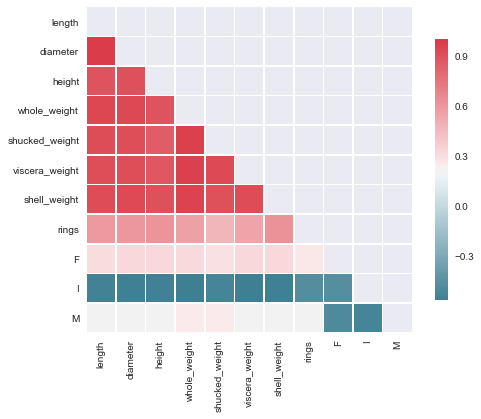

In [49]:
corr_sex_vol = df_sex_enc.corr()
mask = np.zeros_like(corr_sex_vol, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(8, 6))
cmap = sb.diverging_palette(220, 10, as_cmap=True)
sb.heatmap(corr_sex_vol,mask=mask, cmap=cmap, vmax=1,square=True, linewidths=.5, cbar_kws={"shrink": .8}, ax=ax);
plt.savefig(default_figure_out_path+'heatmap_sex_encoded'+default_figure_ext, bbox_inches='tight')

In [50]:
df_sex_enc.loc[:,'volume'] = df_sex_enc['length'].values*df_sex_enc['diameter'].values*df_sex_enc['height'].values
df_sex_enc = df_sex_enc.drop(['length', 'diameter', 'height'], axis='columns')
df_sex_enc.head()

,whole_weight,shucked_weight,viscera_weight,shell_weight,rings,F,I,M,volume
0,0.5140,0.2245,0.1010,0.150,15.0,0,0,1,0.015777
1,0.2255,0.0995,0.0485,0.070,7.0,0,0,1,0.008347
2,0.6770,0.2565,0.1415,0.210,9.0,1,0,0,0.030051
3,0.5160,0.2155,0.1140,0.155,10.0,0,0,1,0.020075
4,0.2050,0.0895,0.0395,0.055,7.0,0,1,0,0.006732


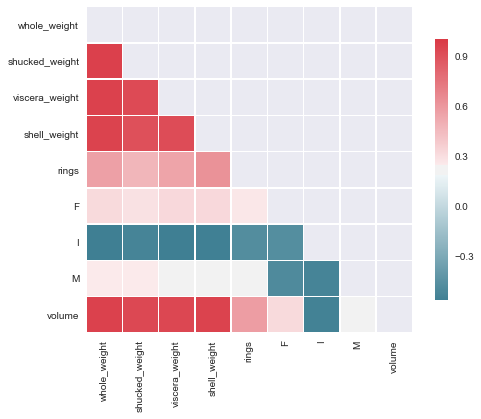

In [51]:
corr_sex_vol = df_sex_enc.corr()
mask = np.zeros_like(corr_sex_vol, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(8, 6))
cmap = sb.diverging_palette(220, 10, as_cmap=True)
sb.heatmap(corr_sex_vol,mask=mask, cmap=cmap, vmax=1,square=True, linewidths=.5, cbar_kws={"shrink": .8}, ax=ax);
plt.savefig(default_figure_out_path+'heatmap_volume_and_sex_encoded'+default_figure_ext, bbox_inches='tight')

In [52]:
# while not mathematically correct for calculating volume of a cylinder it is sufficient as a feature transformation technique
df.loc[:,'volume'] = df['length'].values*df['diameter'].values*df['height'].values
df_volume = df.drop(['length', 'diameter', 'height'], axis='columns')
df_volume.head()

,sex,whole_weight,shucked_weight,viscera_weight,shell_weight,rings,volume
0,M,0.5140,0.2245,0.1010,0.150,15.0,0.015777
1,M,0.2255,0.0995,0.0485,0.070,7.0,0.008347
2,F,0.6770,0.2565,0.1415,0.210,9.0,0.030051
3,M,0.5160,0.2155,0.1140,0.155,10.0,0.020075
4,I,0.2050,0.0895,0.0395,0.055,7.0,0.006732


In [53]:
# df3=df_volume.corr()
# corr3 = df3.corr()
# mask = np.zeros_like(corr3, dtype=np.bool)
# mask[np.triu_indices_from(mask)] = True
# f, ax = plt.subplots(figsize=(8, 6))
# cmap = sb.diverging_palette(220, 10, as_cmap=True)
# sb.heatmap(corr3,mask=mask, cmap=cmap, vmax=1,square=True, linewidths=.5, cbar_kws={"shrink": .8}, ax=ax);
# plt.savefig(default_figure_out_path+'heatmap_with_volume'+default_figure_ext, bbox_inches='tight')

In [75]:
df_volume.corr()

,whole_weight,shucked_weight,viscera_weight,shell_weight,rings,volume,F,I,M
whole_weight,1.000000,0.974949,0.966773,0.962484,0.561778,0.968575,0.317212,-0.566263,0.253069
shucked_weight,0.974949,1.000000,0.931820,0.905760,0.472681,0.935449,0.285103,-0.533319,0.251440
viscera_weight,0.966773,0.931820,1.000000,0.923066,0.547305,0.943111,0.324287,-0.564238,0.244292
shell_weight,0.962484,0.905760,0.923066,1.000000,0.625005,0.958246,0.322262,-0.559439,0.241511
rings,0.561778,0.472681,0.547305,0.625005,1.000000,0.572955,0.263827,-0.474553,0.214010
volume,0.968575,0.935449,0.943111,0.958246,0.572955,1.000000,0.319932,-0.545589,0.230116
F,0.317212,0.285103,0.324287,0.322262,0.263827,0.319932,1.000000,-0.470494,-0.495925
I,-0.566263,-0.533319,-0.564238,-0.559439,-0.474553,-0.545589,-0.470494,1.000000,-0.532919
M,0.253069,0.251440,0.244292,0.241511,0.214010,0.230116,-0.495925,-0.532919,1.000000


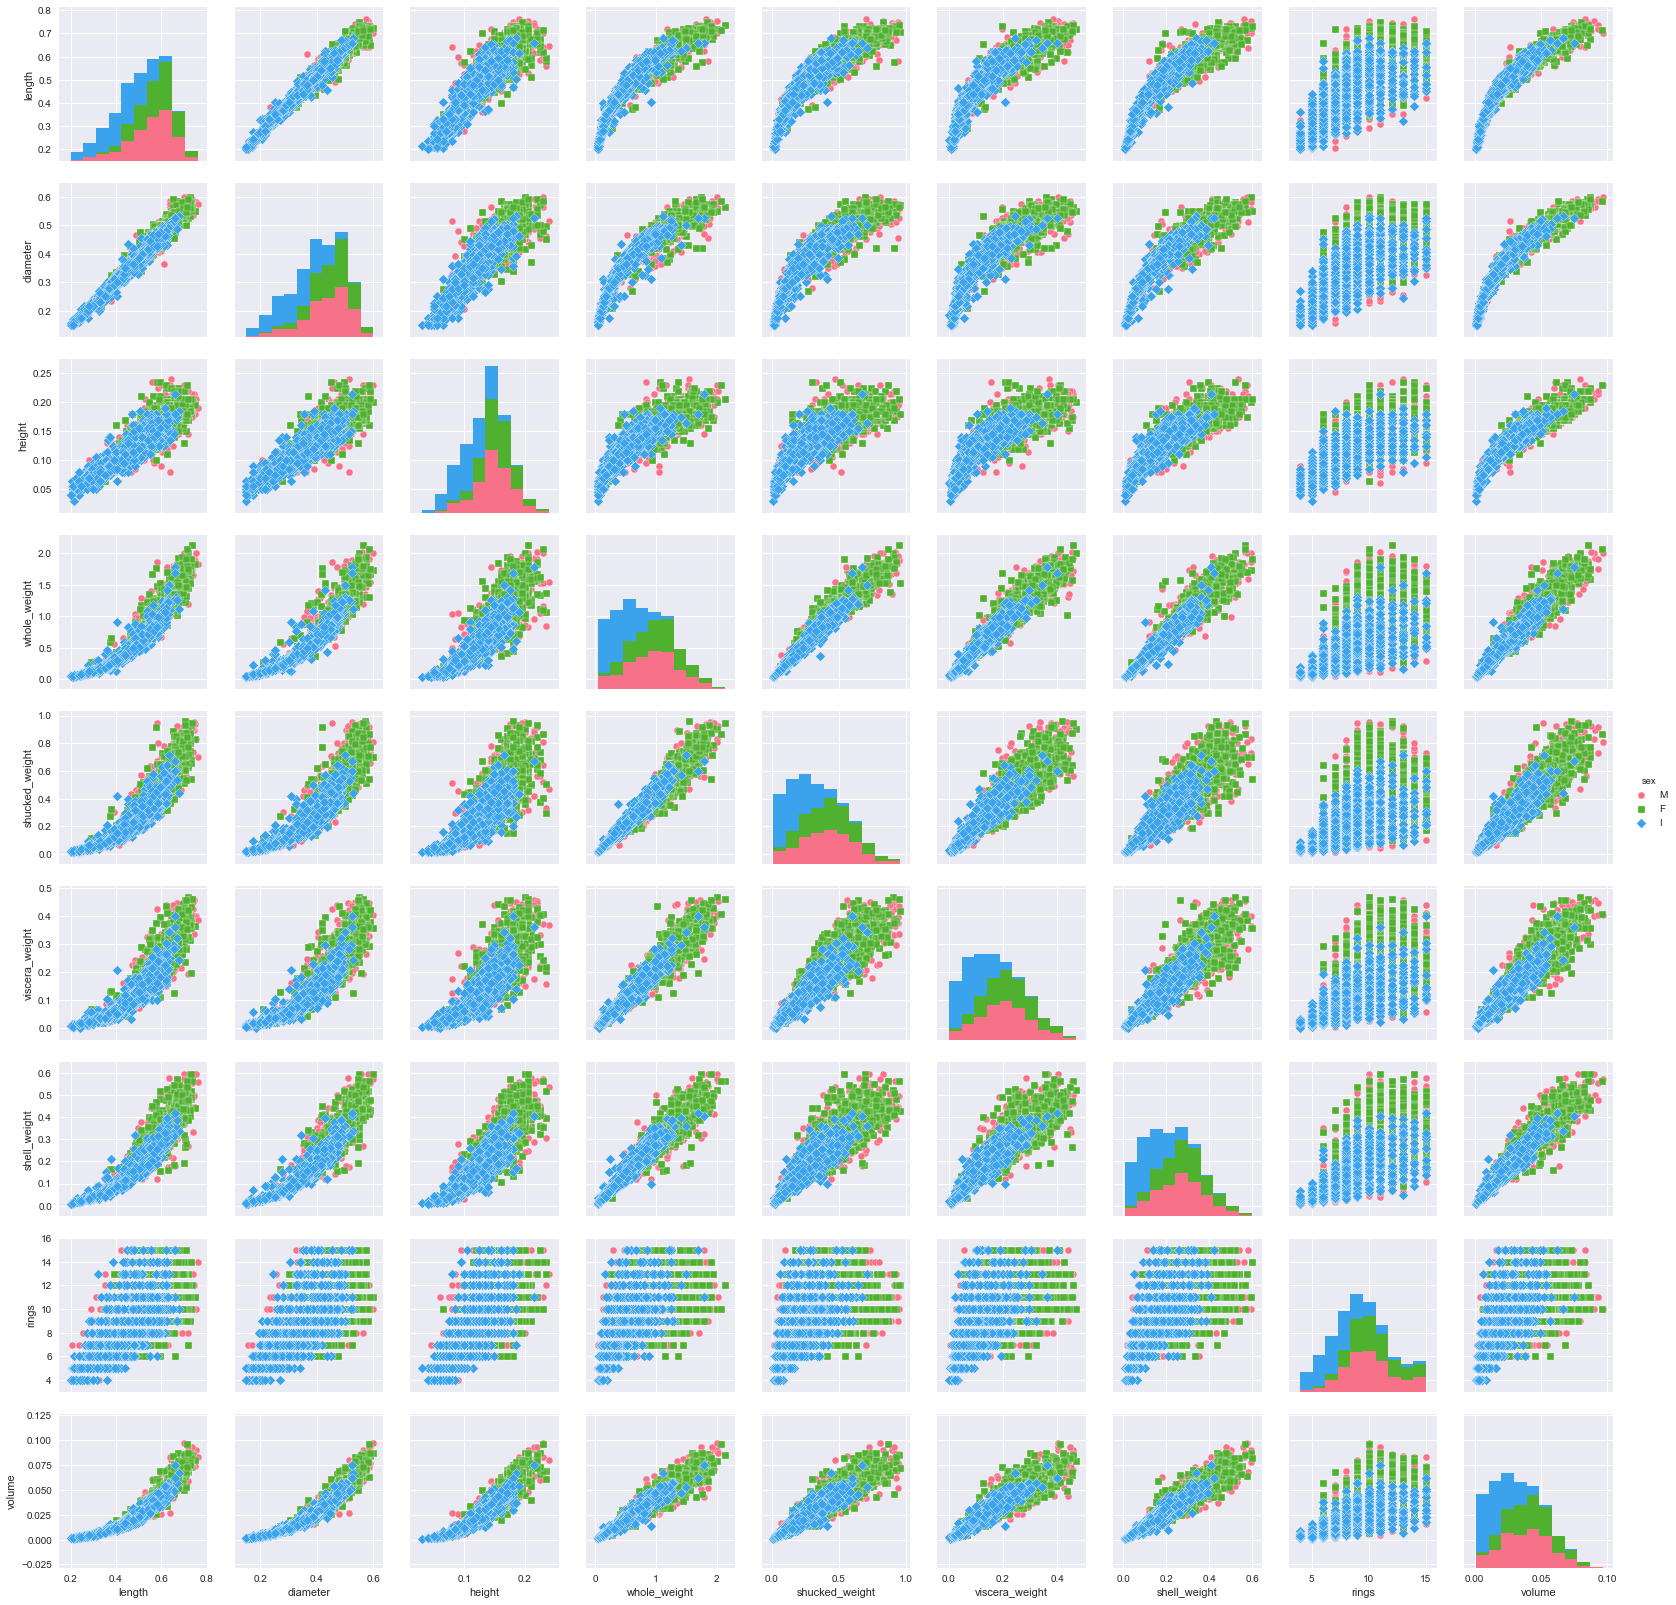

In [55]:
#sb.pairplot(df[['sex', 'length', 'diameter', 'height', 'shell_weight', 'viscera_weight']], hue="sex", palette="husl", markers=["o", "s", "D"])
sb.pairplot(df, hue="sex", palette="husl", markers=["o", "s", "D"])
plt.savefig(default_figure_out_path+'scatter_all_features'+default_figure_ext, bbox_inches='tight')

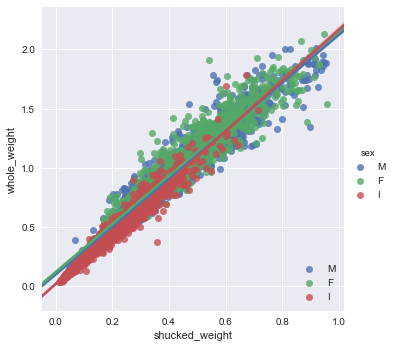

In [56]:
set_7x5_figure()
sb.lmplot( x="shucked_weight", y="whole_weight", data=df, fit_reg=True, hue='sex', legend=True)

#Move the legend to an empty part of the plot
plt.legend(loc='lower right')
plt.savefig(default_figure_out_path+'scatter_shucked_to_whole_weight'+default_figure_ext, bbox_inches='tight')

# Linear Regression

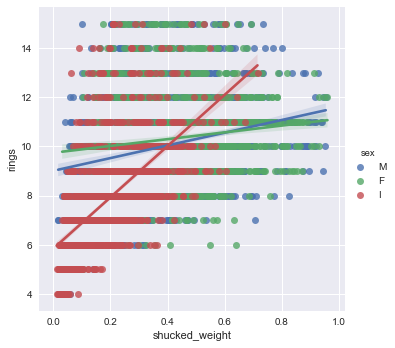

In [57]:
# scatterplot of schucked weight to rings
set_11x8_figure()
g = sb.lmplot(x="shucked_weight", y="rings", hue='sex', truncate=True, size=5, data=df)
plt.savefig(default_figure_out_path+'lin_reg_shucked_to_rings_by_sex'+default_figure_ext, bbox_inches='tight')

## Checking for feature correlation
### Heatmap

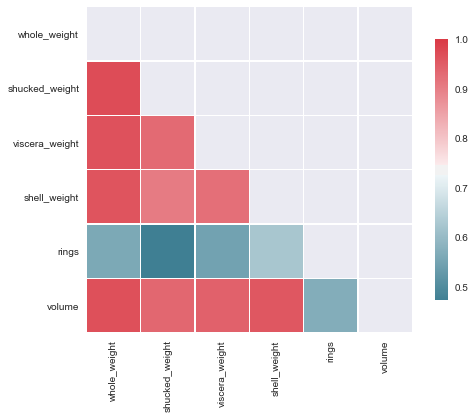

In [58]:
# visualizing feature correlation
corr = df_volume.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(8, 6))
cmap = sb.diverging_palette(220, 10, as_cmap=True)
sb.heatmap(corr, mask=mask, cmap=cmap, vmax=1,square=True, linewidths=.5, cbar_kws={"shrink": .8}, ax=ax);
plt.savefig(default_figure_out_path+'heatmap_with_volume'+default_figure_ext, bbox_inches='tight')

In [59]:
display(df_volume.corr())

,whole_weight,shucked_weight,viscera_weight,shell_weight,rings,volume
whole_weight,1.000000,0.974949,0.966773,0.962484,0.561778,0.968575
shucked_weight,0.974949,1.000000,0.931820,0.905760,0.472681,0.935449
viscera_weight,0.966773,0.931820,1.000000,0.923066,0.547305,0.943111
shell_weight,0.962484,0.905760,0.923066,1.000000,0.625005,0.958246
rings,0.561778,0.472681,0.547305,0.625005,1.000000,0.572955
volume,0.968575,0.935449,0.943111,0.958246,0.572955,1.000000


Since length, diameter and height are higly correlated with one another we can replace them with a new feature - volume


In [60]:
# while not mathematically correct for calculating volume of a cylinder it is sufficient as a feature transformation technique
df.loc[:,'volume'] = df['length'].values*df['diameter'].values*df['height'].values
df_volume = df.drop(['length', 'diameter', 'height'], axis='columns')
df_volume.head()

,sex,whole_weight,shucked_weight,viscera_weight,shell_weight,rings,volume
0,M,0.5140,0.2245,0.1010,0.150,15.0,0.015777
1,M,0.2255,0.0995,0.0485,0.070,7.0,0.008347
2,F,0.6770,0.2565,0.1415,0.210,9.0,0.030051
3,M,0.5160,0.2155,0.1140,0.155,10.0,0.020075
4,I,0.2050,0.0895,0.0395,0.055,7.0,0.006732


In [61]:
df_volume['sex'].unique()

array(['M', 'F', 'I'], dtype=object)

In [62]:
# got to encode sex column using hot-one method as linear regression model only works with quantitative data
encoded_sex = pd.get_dummies(df_volume['sex'])
df_volume = pd.concat([df_volume, encoded_sex], axis='columns')
df_volume = df_volume.drop('sex', axis='columns')

encoded_sex = pd.get_dummies(df['sex'])
df = pd.concat([df, encoded_sex], axis='columns')
df = df.drop('sex', axis='columns')

display(df_volume.head(),df.head())

,whole_weight,shucked_weight,viscera_weight,shell_weight,rings,volume,F,I,M
0,0.5140,0.2245,0.1010,0.150,15.0,0.015777,0,0,1
1,0.2255,0.0995,0.0485,0.070,7.0,0.008347,0,0,1
2,0.6770,0.2565,0.1415,0.210,9.0,0.030051,1,0,0
3,0.5160,0.2155,0.1140,0.155,10.0,0.020075,0,0,1
4,0.2050,0.0895,0.0395,0.055,7.0,0.006732,0,1,0


,length,diameter,height,whole_weight,shucked_weight,viscera_weight,shell_weight,rings,volume,F,I,M
0,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15.0,0.015777,0,0,1
1,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7.0,0.008347,0,0,1
2,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9.0,0.030051,1,0,0
3,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10.0,0.020075,0,0,1
4,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7.0,0.006732,0,1,0


### Lasso method
Lasso method is used to check not only for correlated features but also applies a penalty to the feature selection and fitting to model. This ensures that only the most suitable featurs are selected for further modelling

In [63]:
#Using lasso to determine features most contributing towards prediction of rings

X = df_volume.drop(['rings'], axis='columns')  # X = features
y = df_volume['rings']                       # y = prediction target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
lasso = Lasso(alpha=1.1, normalize=True)

lasso.fit(X_train, y_train)
lasso_coef=lasso.coef_

print("Lasso score:",lasso.score(X_test, y_test), lasso_coef)

Lasso score: -9.544197401734067e-06 [ 0.  0.  0.  0.  0.  0. -0.  0.]


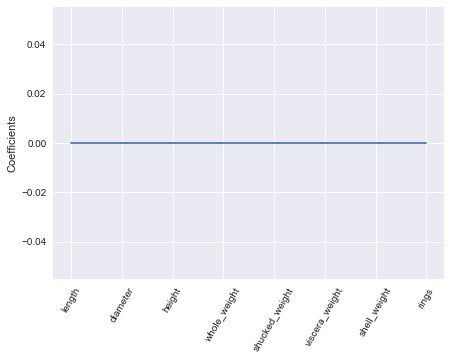

In [76]:
set_7x5_figure()
_ = plt.plot(range(X_train.shape[1]), lasso_coef)
_ = plt.xticks(range(X_train.shape[1]), df, rotation=60)
_ = plt.ylabel('Coefficients')
plt.show()
plt.savefig(default_figure_out_path+'lasso_coefficients_plot'+default_figure_ext, bbox_inches='tight')

## Dummy Model
Dummy model regression can act as a baseline to base result of improved models upon

Mean absolute error: 		1.870800
Standard deviation of the error: 2.337150
RSS score:			 0.0


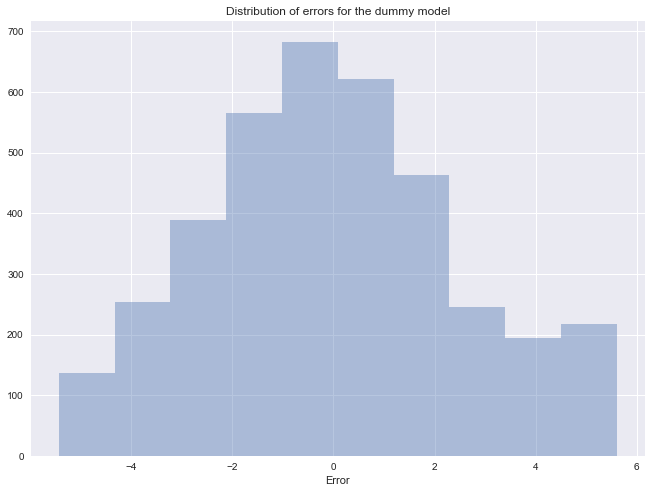

In [65]:
# chosing rings as a feature to predict as to predict age of abalone one needs to be able to predict its number of rings
X = df.drop('rings', axis='columns')  # X = features
y = df['rings']                       # y = prediction target
model = DummyRegressor()
outer_cv = KFold(n_splits=5, shuffle=True, random_state=0)  # 5 fold cross validation
y_pred = cross_val_predict(model, X, y, cv=outer_cv)        # Make predictions via cross validation

print('Mean absolute error: \t\t%f' % mean_absolute_error(y, y_pred))
print('Standard deviation of the error: %f' % (y - y_pred).std())

set_11x8_figure()
ax = sb.distplot(y - y_pred, bins=10, kde=False)

ax.set(
    title='Distribution of errors for the dummy model',
    xlabel='Error'
);
plt.savefig(default_figure_out_path+'distribution_of_errors_in_dummy_regression_5_folds'+default_figure_ext, bbox_inches='tight')
model.fit(X,y)
rss_dummy=model.score(X,y)
print('RSS score:\t\t\t',rss_dummy)

Mean absolute error:		 1.870800
Standard deviation of the error: 2.337150
RSS score:			 0.0


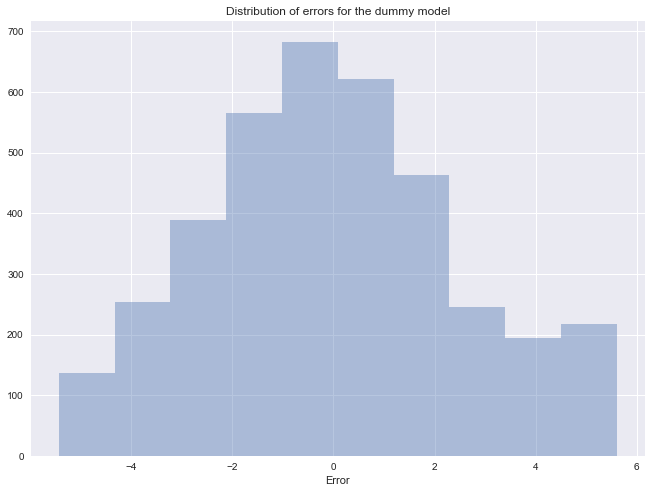

In [66]:
# checking if increasing the number of k-folds will change the values
X = df_volume.drop('rings', axis='columns')  # X = features
y = df_volume['rings']                       # y = prediction target
model = DummyRegressor()
outer_cv = KFold(n_splits=5, shuffle=True, random_state=0)  # 10 fold cross validation
y_pred = cross_val_predict(model, X, y, cv=outer_cv)        # Make predictions via cross validation

dummy_std=(y - y_pred).std()
mean_abs_error_dummy = mean_absolute_error(y, y_pred)
print('Mean absolute error:\t\t %f' % mean_abs_error_dummy)
print('Standard deviation of the error: %f' % dummy_std)

ax = sb.distplot(y - y_pred, bins=10, kde=False)

ax.set(
    title='Distribution of errors for the dummy model',
    xlabel='Error'
);

model.fit(X, y)
model.score(X, y)
print('RSS score:\t\t\t', model.score(X,y))
plt.savefig(default_figure_out_path+'distribution_of_errors_in_dummy_regression__volume'+default_figure_ext, bbox_inches='tight')

The best score to get out of a prediction, or regression, model is 0 as it would mean that the predicted and actual data matched up. The above graph we can observer that majority of the data is centered around 0, however at the same time significant portion of the dataset is significantly away from the 0 error value. 
Mean absolute error score is at almost 2 which means that the dummy model leaves room for improvement.

There is no improvement observed on the model with size features combined into volume either.

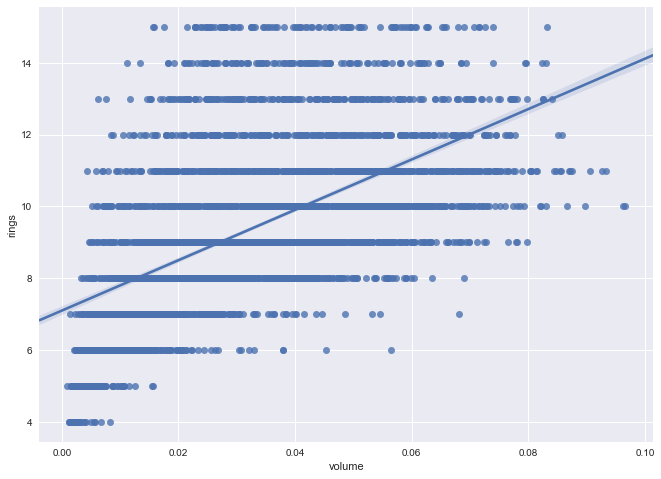

In [67]:
sb.regplot(x="volume", y="rings", data=df, fit_reg=True);
plt.savefig(default_figure_out_path+'linear_reg_graph_volume_rings_dummy'+default_figure_ext, bbox_inches='tight')

## Linear Regression

Mean absolute error: 			 1.247948
Standard deviation of the error: 	 1.615670
RSS score:			 0.5245940479483604

Cross validation scores
 	Mean:			 0.4607723039409805 
	Standard deviation:	 0.07422181989850539


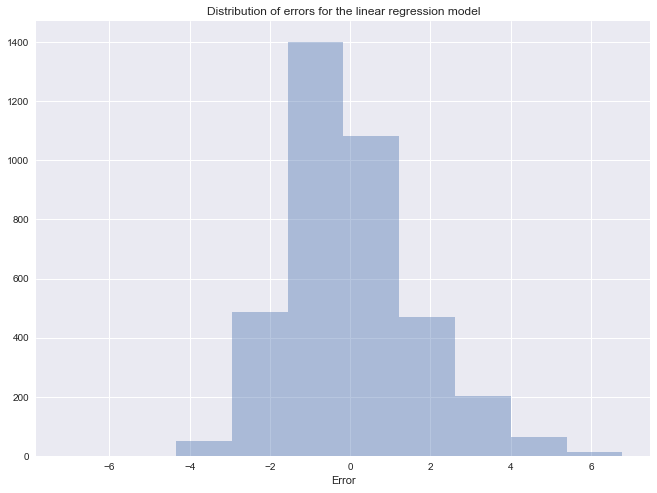

In [68]:
# to compare dummy model with linear regression one, likes with likes need to be compared, so chosing rings 
# feature for analysis again
X = df.drop('rings', axis='columns')  # X = features
y = df['rings']                       # y = prediction target

model = LinearRegression(fit_intercept=True, normalize=False)  # Use least squares linear regression

outer_cv = KFold(n_splits=5, shuffle=True, random_state=0)  # 5-fold cross validation
y_pred = cross_val_predict(model, X, y, cv=outer_cv)
cv_scores = cross_val_score(model, X, y, cv=5)        # Make predictions via cross validation

linear_std = (y - y_pred).std()
mean_abs_error = mean_absolute_error(y, y_pred)
print('Mean absolute error: \t\t\t %f' % mean_abs_error)
print('Standard deviation of the error: \t %f' % linear_std)

ax = sb.distplot(y - y_pred, bins=10, kde=False)
ax.set(
    title='Distribution of errors for the linear regression model',
    xlabel='Error'
);
model.fit(X, y)
rss_score_lin = model.score(X,y)
print('RSS score:\t\t\t',rss_score_lin)
print("\nCross validation scores\n \tMean:\t\t\t",np.mean(cv_scores),"\n\tStandard deviation:\t", np.std(cv_scores))
plt.savefig(default_figure_out_path+'distribution_of_errors_in_linear_regression'+default_figure_ext, bbox_inches='tight')

## Linear regression with size features combined

Mean absolute error: 			 1.306114
Standard deviation of the error: 	 1.615670
RSS score:			 0.4772865587953042

Cross validation scores
 	Mean:			 0.4172033362680721 
	Standard deviation:	 0.05725167101717696


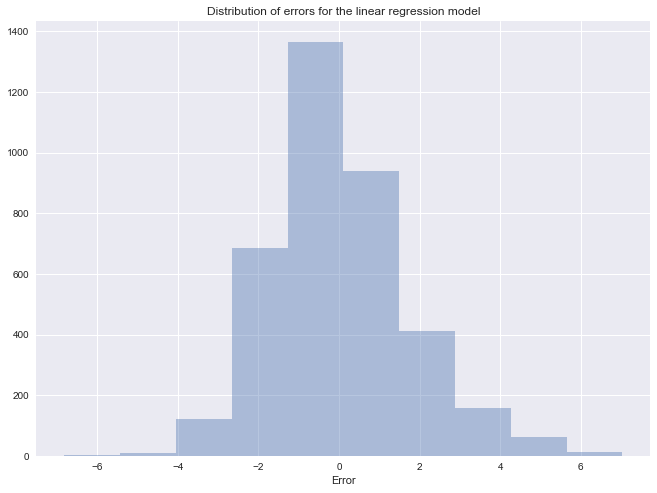

In [69]:
# to compare dummy model with linear regression one, likes with likes need to be compared, so chosing rings 
# feature for analysis again
X = df_volume.drop('rings', axis='columns')  # X = features
y = df_volume['rings']                       # y = prediction target

model = LinearRegression(fit_intercept=True, normalize=False)  # Use least squares linear regression

outer_cv = KFold(n_splits=5, shuffle=True, random_state=0)  # 5-fold cross validation
y_pred = cross_val_predict(model, X, y, cv=outer_cv)
cv_scores = cross_val_score(model, X, y, cv=5)        # Make predictions via cross validation

linear_std_volume = (y - y_pred).std()
mean_abs_error_volume = mean_absolute_error(y, y_pred)
print('Mean absolute error: \t\t\t %f' % mean_abs_error_volume)
print('Standard deviation of the error: \t %f' % linear_std)

ax = sb.distplot(y - y_pred, bins=10, kde=False)
ax.set(
    title='Distribution of errors for the linear regression model',
    xlabel='Error'
);
model.fit(X, y)
rss_score_lin_volume = model.score(X,y)
print('RSS score:\t\t\t', rss_score_lin_volume)
print("\nCross validation scores\n \tMean:\t\t\t",np.mean(cv_scores),"\n\tStandard deviation:\t", np.std(cv_scores))
plt.savefig(default_figure_out_path+'distribution_of_errors_in_linear_regression_volume'+default_figure_ext, bbox_inches='tight')

## Summary of Linear regression findings

In [70]:
def format_dec(dec):
    return format(dec, '2.4')
summary_header='\nDummy\tLinear\tLinear with Volume\n'
    

# std deviation improvement ratio over dummy model
#print('Linear regression improvement of std deviation over dummy model:',format_dec(dummy_std- *100), '%')
#print('Linear regression with volume feature improvement of std deviation over dummy model:',format_dec(linear_std_volume/dummy_std *100), '%')
print('\nStandard deviation:',summary_header,format_dec(dummy_std),'\t', format_dec(linear_std), '\t',format_dec(linear_std_volume))
print('\nMean absolute error:', summary_header, format_dec(mean_abs_error_dummy), '\t', format_dec(mean_abs_error), '\t', format_dec(mean_abs_error_volume))
print('\nRSS Scores', summary_header,format_dec(rss_dummy), format_dec(rss_score_lin), format_dec(rss_score_lin_volume))


Standard deviation: 
Dummy	Linear	Linear with Volume
 2.337 	 1.616 	 1.692

Mean absolute error: 
Dummy	Linear	Linear with Volume
 1.871 	 1.248 	 1.306

RSS Scores 
Dummy	Linear	Linear with Volume
 0.0 0.5246 0.4773


With the linear regression model graph above we have twice as many data points centered around 0 value as with dummy model. The mean absolute error is singificantly closer to 0 error rate as well. We see plainly that we've made improvemets to the model. What is also significant is that the dispersion of error measured with standard deviation is improved on simply by changing the model.
With the combining of size features into `volume` one we see that dispersion of error goes up slightly but at the same time the residuals metrics measured by RSS score decrease making Linear Regression with combined size features the best model so far.

# Decision Tree Regression

In [71]:
X = df_volume.drop('rings', axis='columns')  # X = features
y = df_volume['rings']                       # y = prediction target

train_X, test_X, train_y, test_y = cross_validation.train_test_split(X, y) # splits 75%/25% by default
# create an estimator, optionally specifying parameters
model = DecisionTreeRegressor()
# fit the estimator to the data
model.fit(train_X, train_y)
# apply the model to the test and training data
predicted_test_y = model.predict(test_X)
predicted_train_y = model.predict(train_X)

In [72]:
def scatter_y(true_y, predicted_y):
    """Scatter-plot the predicted vs true number of rings
    
    Plots:
       * predicted vs true number of rings
       * perfect agreement line
       * +2/-2 number dotted lines

    Returns the root mean square of the error
    """
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.plot(true_y, predicted_y, '.k')
    
    ax.plot([0, 30], [0, 30], '--k')
    ax.plot([0, 30], [2, 32], ':k')
    ax.plot([2, 32], [0, 30], ':k')
    
    rms = (true_y - predicted_y).std()
    
    ax.text(25, 3,
            "Root Mean Square Error = %.2g" % rms,
            ha='right', va='bottom')

    ax.set_xlim(0, 30)
    ax.set_ylim(0, 30)
    
    ax.set_xlabel('True number of rings')
    ax.set_ylabel('Predicted number of rings')
    
    return rms

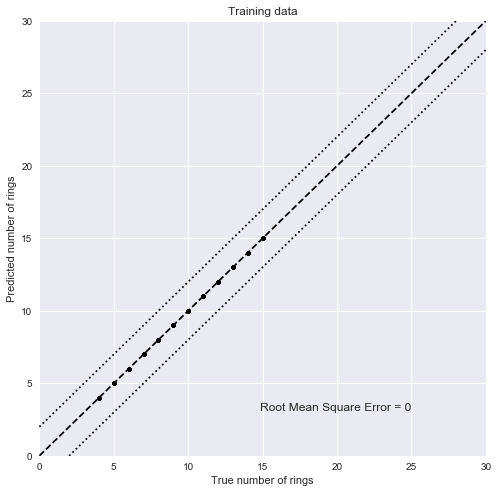

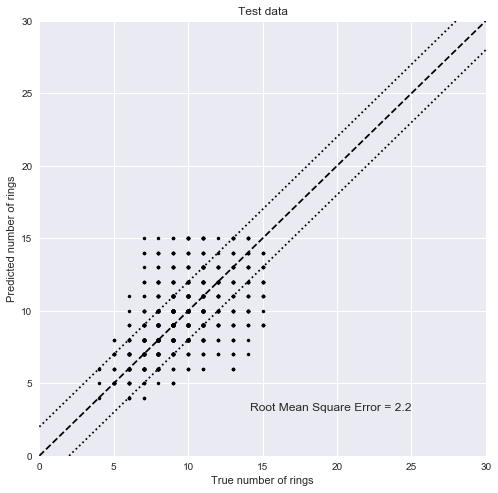

In [73]:
scatter_y(train_y, predicted_train_y)
plt.title("Training data")
scatter_y(test_y, predicted_test_y)
plt.title("Test data");

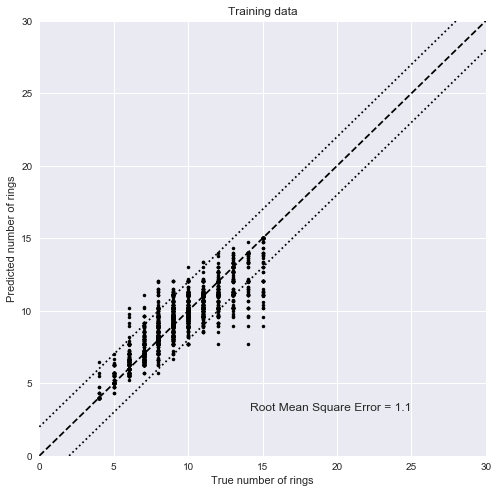

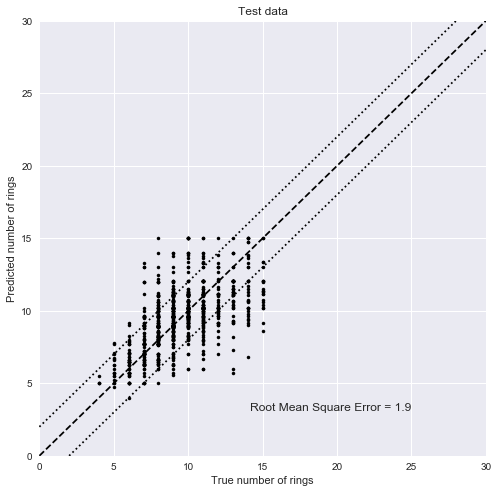

In [74]:
model = DecisionTreeRegressor(max_depth=10)
# fit the estimator to the data
model.fit(train_X, train_y)
# apply the model to the test and train data
predicted_test_y = model.predict(test_X)
predicted_train_y = model.predict(train_X)
scatter_y(train_y, predicted_train_y)
plt.title("Training data")
rms_decision_tree = scatter_y(test_y, predicted_test_y)
plt.title("Test data");